In [1]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import train_test_split


In [2]:
# Import necessary libraries for data handling and preprocessing
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Load the training dataset from a CSV file
# - `SPY.csv` is assumed to contain historical stock market data
train_file_path = "SPY.csv"  # Specify the path to your training data file
train_data = pd.read_csv(train_file_path)  # Load the data into a pandas DataFrame

# Convert the 'Date' column to datetime format
# - This ensures proper handling of dates for time-series analysis
train_data['Date'] = pd.to_datetime(train_data['Date'])

# Set the 'Date' column as the DataFrame's index
# - This makes it easier to plot and manage data chronologically
train_data.set_index('Date', inplace=True)

# Extract the 'Close' prices as a NumPy array
# - 'Close' represents the closing price of the stock for each day, our target variable
train_close_prices = train_data['Close'].values

# Normalize the data using MinMaxScaler
# - Scales the data to a range between 0 and 1, which helps the model converge faster
# - Normalization is crucial for neural networks to perform well
scaler = MinMaxScaler()  # Initialize the scaler
scaled_train_prices = scaler.fit_transform(train_close_prices.reshape(-1, 1))  # Reshape and scale data

# Function to create input sequences and corresponding target values for time-series modeling
# Input:
#   - data: normalized price data
#   - sequence_length: number of time steps (days) to include in each input sequence
# Output:
#   - X: array of sequences of historical prices
#   - y: array of target values (the next day's price for each sequence)
def create_sequences(data, sequence_length):
    X, y = [], []  # Initialize empty lists for inputs and targets
    for i in range(len(data) - sequence_length):  # Loop through the data
        X.append(data[i:i + sequence_length])  # Append a sequence of `sequence_length` prices
        y.append(data[i + sequence_length])   # Append the price following the sequence
    return np.array(X), np.array(y)  # Convert lists to NumPy arrays for model compatibility

# Set the number of days to look back for each sequence
sequence_length = 30  # Use 30 days of historical data to predict the next day's price

# Generate sequences (X) and targets (y) from the scaled price data
X_full, y_full = create_sequences(scaled_train_prices, sequence_length)

# Split the data into training and validation sets
# - `test_size=0.1`: 10% of the data is reserved for validation
# - `shuffle=False`: Data is not shuffled to preserve chronological order
# - `random_state=42`: Ensures reproducibility of the split
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.1, random_state=42, shuffle=False
)

# `X_train` and `y_train`: Training data for the model
# `X_val` and `y_val`: Validation data to monitor the model's performance during training

In [3]:
# Import necessary TensorFlow modules for building the LSTM model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

# Function to build an LSTM (Long Short-Term Memory) model for time-series forecasting
# Input:
#   - input_shape: the shape of the input data (sequence length, number of features)
# Output:
#   - A compiled Keras model ready for training
def build_lstm_model(input_shape):
    # Define the input layer with the specified input shape
    # - input_shape: (sequence_length, 1 feature)
    inputs = Input(shape=input_shape)

    # First LSTM layer
    # - `units=64`: The number of LSTM units (memory cells)
    # - `return_sequences=True`: Returns the full sequence of outputs for stacking layers
    x = LSTM(units=64, return_sequences=True)(inputs)

    # Dropout layer to reduce overfitting
    # - `rate=0.2`: Drops 20% of the neurons randomly during training
    x = Dropout(0.2)(x)

    # Second LSTM layer
    # - `units=32`: Fewer units in the second layer to reduce model complexity
    # - `return_sequences=False`: Only the last output is returned
    x = LSTM(units=32, return_sequences=False)(x)

    # Another Dropout layer for regularization
    x = Dropout(0.2)(x)

    # Dense output layer
    # - `units=1`: Single output for predicting the next day's price
    # - `activation="linear"`: No activation function, as this is a regression task
    outputs = Dense(1, activation="linear")(x)

    # Create the Keras model by specifying the inputs and outputs
    model = Model(inputs, outputs)
    return model

# Build the LSTM model
# - `sequence_length`: Number of days in each input sequence
# - `1`: One feature (the closing price)
model = build_lstm_model((sequence_length, 1))

# Compile the model with the Adam optimizer and Mean Squared Error (MSE) loss function
# - `optimizer=tf.keras.optimizers.Adam`: Adaptive learning rate optimizer
# - `learning_rate=0.001`: The initial learning rate
# - `loss="mse"`: MSE is suitable for regression tasks
# - `metrics=["mae"]`: Additional metric to monitor during training, Mean Absolute Error (MAE)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae"])

# The model is now compiled and ready for training.

In [4]:
# Train the LSTM model on the training data
# - `model.fit`: This method trains the model and evaluates it on the validation set during each epoch

history = model.fit(
    X_train,  # Training input data (sequences of scaled closing prices)
    y_train,  # Training target data (the next day's scaled closing price)
    
    validation_data=(X_val, y_val),  # Validation data (input and target) to monitor model performance
    
    epochs=30,  # Number of complete passes through the training dataset
    # - Too few epochs may result in underfitting
    # - Too many epochs may result in overfitting
    
    batch_size=32  # Number of samples per gradient update
    # - Smaller batch sizes provide more granular weight updates but can be slower
    # - Larger batch sizes improve efficiency but require more memory
)

# Key Details of the Training Process:
# 1. During each epoch:
#    - The model processes the `X_train` input to predict `y_train`.
#    - It calculates the loss (difference between predictions and actual values) using the "mse" loss function.
#    - The model's weights are updated using the Adam optimizer to minimize the loss.
# 2. Validation:
#    - After each epoch, the model evaluates its performance on the validation data (`X_val`, `y_val`).
#    - Validation loss and metrics provide an indication of how well the model generalizes to unseen data.

# The `history` object stores the training and validation loss/metrics for each epoch.
# This can be used to analyze the training process and adjust hyperparameters if needed.

Epoch 1/30
113/113 [==============================] - 11s 18ms/step - loss: 0.0077 - mae: 0.0554 - val_loss: 0.0031 - val_mae: 0.0518
Epoch 2/30
113/113 [==============================] - 1s 13ms/step - loss: 0.0022 - mae: 0.0328 - val_loss: 5.2098e-04 - val_mae: 0.0177
Epoch 3/30
113/113 [==============================] - 3s 29ms/step - loss: 0.0018 - mae: 0.0298 - val_loss: 7.7442e-04 - val_mae: 0.0241
Epoch 4/30
113/113 [==============================] - 2s 13ms/step - loss: 0.0016 - mae: 0.0283 - val_loss: 6.3270e-04 - val_mae: 0.0173
Epoch 5/30
113/113 [==============================] - 1s 13ms/step - loss: 0.0014 - mae: 0.0267 - val_loss: 0.0015 - val_mae: 0.0350
Epoch 6/30
113/113 [==============================] - 1s 13ms/step - loss: 0.0013 - mae: 0.0252 - val_loss: 0.0010 - val_mae: 0.0282
Epoch 7/30
113/113 [==============================] - 1s 13ms/step - loss: 0.0012 - mae: 0.0246 - val_loss: 0.0013 - val_mae: 0.0324
Epoch 8/30
113/113 [==============================] - 1s

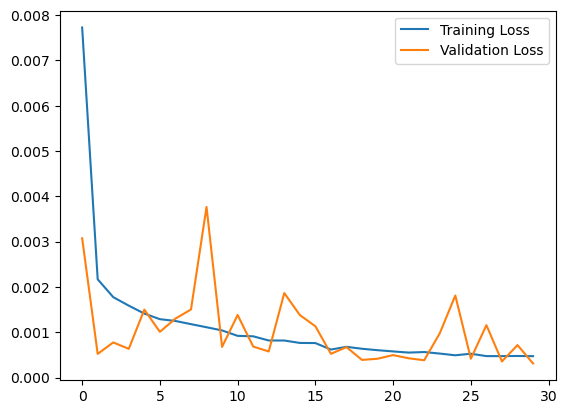

In [5]:
# Plot the training and validation loss over the epochs
# This visualization helps assess the model's learning progress and identify overfitting or underfitting

plt.plot(history.history['loss'], label='Training Loss')  # Plot training loss values over epochs
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss values over epochs

# Add a legend to distinguish between the training and validation loss curves
plt.legend()

# Add labels and a title to make the plot informative
plt.xlabel("Epochs")  # X-axis represents the number of epochs
plt.ylabel("Loss")  # Y-axis represents the loss values (MSE in this case)
plt.title("Training and Validation Loss")  # Title of the plot

# Display the plot
plt.show()

In [7]:
# Load the testing dataset from a CSV file
# - `SPY_Test.csv` is assumed to contain historical stock market data for testing
test_file_path = "SPY_Test.csv"  # Specify the path to your testing data file
test_data = pd.read_csv(test_file_path)  # Load the test data into a pandas DataFrame

# Convert the 'Date' column to datetime format
# - This ensures proper handling of dates for time-series analysis
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Set the 'Date' column as the DataFrame's index
# - This aligns the testing data with the same structure as the training data
test_data.set_index('Date', inplace=True)

# Extract the 'Close' prices as a NumPy array
# - 'Close' represents the closing price of the stock for each day
test_close_prices = test_data['Close'].values

# Normalize the test data using the same scaler fitted on the training data
# - It is important to use the same scaler to ensure consistency in data scaling
scaled_test_prices = scaler.transform(test_close_prices.reshape(-1, 1))

# Prepare the test dataset for making predictions
# Use the `create_sequences` function to generate input sequences (X) and corresponding targets (y)
# - `scaled_test_prices`: normalized test price data
# - `sequence_length`: number of time steps in each input sequence
X_test, y_test = create_sequences(scaled_test_prices, sequence_length)

# The `X_test` data is now ready for predictions using the trained model.
# The `y_test` data contains the true values (next day's price) for evaluation.

31/31 [==============================] - 3s 14ms/step


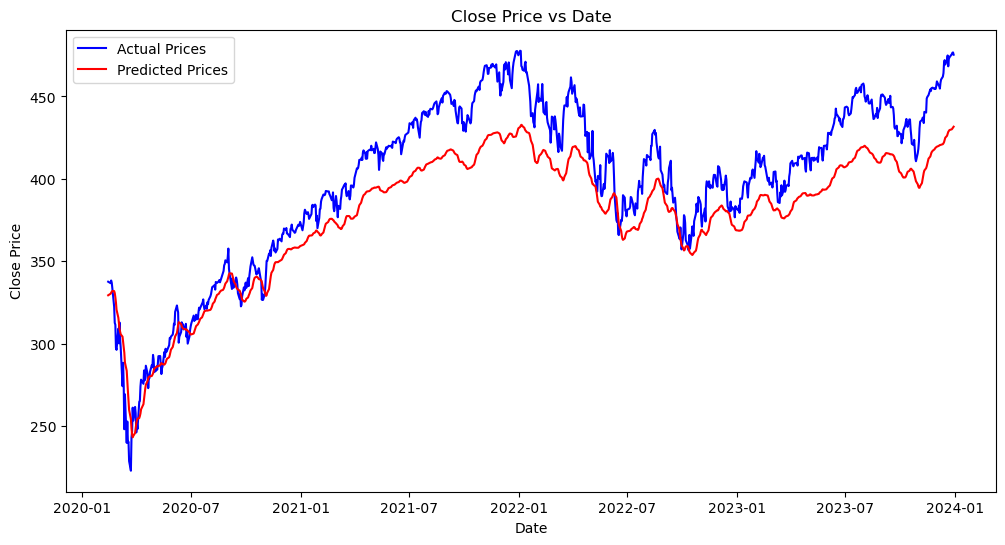

In [8]:
# Make predictions on the test data using the trained model
# - `X_test`: Input sequences of scaled closing prices from the test dataset
# - `y_pred`: Model's predicted scaled values for the next day's price
y_pred = model.predict(X_test)

# Rescale the predicted values back to their original scale
# - The model's predictions are on the normalized scale, so we reverse the normalization
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Rescale the true test values back to their original scale
# - The true target values (`y_test`) are also on the normalized scale
# - Rescaling these allows us to compare them directly with the predicted values
y_test_rescaled = scaler.inverse_transform(y_test)

# Plot the actual and predicted prices to visualize model performance
plt.figure(figsize=(12, 6))  # Set the figure size for better visualization

# Plot the actual prices
# - Use the test dataset's dates to align the actual prices on the X-axis
plt.plot(test_data.index[-len(y_test_rescaled):], y_test_rescaled, label="Actual Prices", color="blue")

# Plot the predicted prices
# - Align the predicted prices on the same X-axis (dates) as the actual prices
plt.plot(test_data.index[-len(y_pred_rescaled):], y_pred_rescaled, label="Predicted Prices", color="red")

# Add labels, title, and legend to the plot for clarity
plt.xlabel("Date")  # X-axis represents the dates from the test dataset
plt.ylabel("Close Price")  # Y-axis represents the stock's closing prices
plt.title("Close Price vs Date")  # Title of the plot
plt.legend()  # Legend distinguishes between actual and predicted prices

# Display the plot
plt.show()